# Decoding Multi-Hop Arithmetic Intermediates from Hidden States

Can a model compute intermediate reasoning steps during a single forward pass?

We generate bracketed arithmetic with clear hop structure (e.g. `(((2 + 3) * 4) - 5)`),
run the model, and use linear probes at each layer to detect when intermediates become decodable.

Inspired by [Ryan Greenblatt's blogpost](https://www.redwoodresearch.com/blog/filler-tokens) on filler tokens and no-CoT math performance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lib import MODEL_NAME, generate_data, extract_hidden_states, compute_accuracy, train_probes

## Config

In [2]:
##############################
#  MODEL: see lib.MODEL_NAME #
##############################
print(f"Model: {MODEL_NAME}")

Model: Qwen/Qwen3-0.6B


## 1. Generate data

Left-chained bracketed arithmetic: `(((a + b) * c) - d)`
- 1000 examples each for 2-hop, 3-hop, 4-hop, 5-hop
- Operands: 2–9, operations: `+`, `-`, `*`

In [3]:
examples = generate_data()
print(f"{len(examples)} examples")
for ex in examples[:3]:
    print(f"  {ex.prompt}  →  intermediates={ex.intermediates}")

Generating data:   0%|          | 0/4 [00:00<?, ?it/s]

4000 examples
  Compute: ((3 + 2) + 6) =  →  intermediates=[5, 11]
  Compute: ((4 * 3) - 3) =  →  intermediates=[12, 9]
  Compute: ((2 + 2) + 3) =  →  intermediates=[4, 7]


## 2. Extract hidden states

Run the model on all prompts, collecting the last-token hidden state at every layer.
Also greedy-decode a few tokens to check model accuracy. Results are cached to `data/hidden_states.pt`.

In [4]:
data = extract_hidden_states(examples)
print(f"Hidden states shape: {data['hidden_states'].shape}")

Loading cached hidden states from data/hidden_states.pt
Hidden states shape: torch.Size([4000, 29, 1024])


### Model accuracy

Does the model actually get the right answer in text? (Spoiler: mostly no — which makes the probing results more interesting.)

In [5]:
acc = compute_accuracy(examples, data["predictions"])
for nhops, (correct, total) in acc.items():
    print(f"  {nhops}-hop: {correct}/{total} = {correct/total:.1%}")

  2-hop: 0/1000 = 0.0%
  3-hop: 0/1000 = 0.0%
  4-hop: 0/1000 = 0.0%
  5-hop: 0/1000 = 0.0%


## 3. Train linear probes

For each (layer, hop_level): Ridge regression from hidden state → intermediate value.
- For hop_level k, we use all examples with nhops ≥ k
- 80/20 train/test split, report R² on test set

In [6]:
r2_matrix = train_probes(data)
print(f"R² matrix shape: {r2_matrix.shape}  (layers × hops)")

Hop levels:   0%|          | 0/5 [00:00<?, ?it/s]

  Layers (hop 1):   0%|          | 0/29 [00:00<?, ?it/s]

/ceph/scratch/jbauer/venvs/ml/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:228: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.840483983225567e-08.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/ceph/scratch/jbauer/venvs/ml/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:228: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 8.674879836689797e-08.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/ceph/scratch/jbauer/venvs/ml/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:228: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 7.012144465079473e-08.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/ceph/scratch/jbauer/venvs/ml/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:228: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 5.348486098455396e-08.
  return linalg.solve(A, Xy, assume_a="pos", over

  Layers (hop 2):   0%|          | 0/29 [00:00<?, ?it/s]

/ceph/scratch/jbauer/venvs/ml/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:228: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.840483983225567e-08.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/ceph/scratch/jbauer/venvs/ml/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:228: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 8.674879836689797e-08.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/ceph/scratch/jbauer/venvs/ml/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:228: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 7.012144465079473e-08.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/ceph/scratch/jbauer/venvs/ml/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:228: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 5.348486098455396e-08.
  return linalg.solve(A, Xy, assume_a="pos", over

  Layers (hop 3):   0%|          | 0/29 [00:00<?, ?it/s]

/ceph/scratch/jbauer/venvs/ml/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:228: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 1.0960783214386538e-07.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/ceph/scratch/jbauer/venvs/ml/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:228: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.507682108278459e-08.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/ceph/scratch/jbauer/venvs/ml/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:228: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 1.0386588655819651e-07.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/ceph/scratch/jbauer/venvs/ml/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:228: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 5.8795741608719254e-08.
  return linalg.solve(A, Xy, assume_a="pos", o

  Layers (hop 4):   0%|          | 0/29 [00:00<?, ?it/s]

/ceph/scratch/jbauer/venvs/ml/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:228: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 8.073208590531067e-08.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


  Layers (hop 5):   0%|          | 0/29 [00:00<?, ?it/s]

R² matrix shape: (29, 5)  (layers × hops)


### R² heatmap

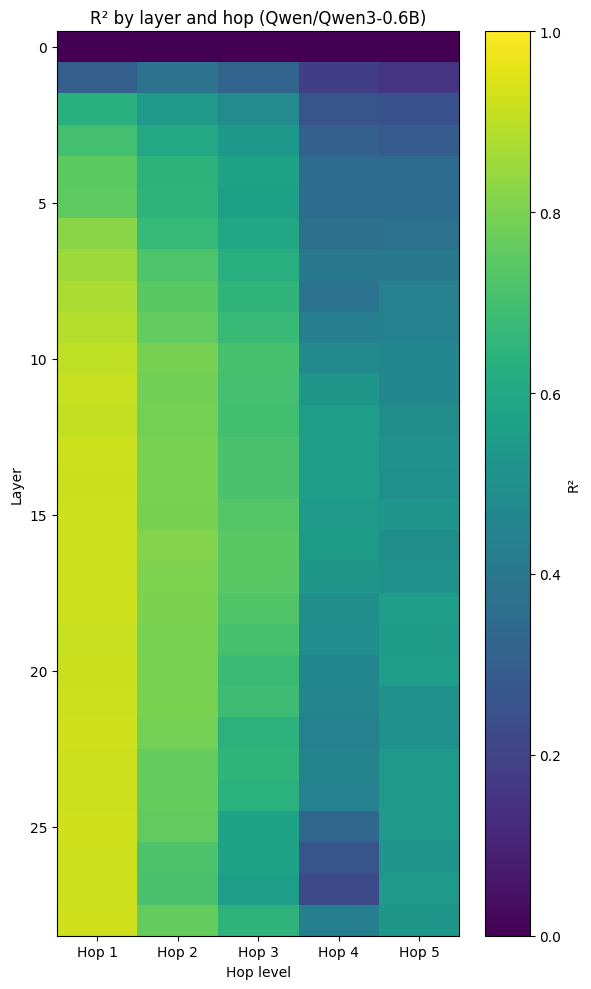

In [7]:
fig, ax = plt.subplots(figsize=(6, 10))
im = ax.imshow(r2_matrix, aspect="auto", cmap="viridis", vmin=0, vmax=1)
ax.set_xlabel("Hop level")
ax.set_ylabel("Layer")
ax.set_xticks(range(r2_matrix.shape[1]))
ax.set_xticklabels([f"Hop {i+1}" for i in range(r2_matrix.shape[1])])
ax.set_title(f"R² by layer and hop ({MODEL_NAME})")
fig.colorbar(im, ax=ax, label="R²")
fig.tight_layout()
plt.show()

## 4. Plots

### Plot 1: Number of hops decodable per layer

For each layer, count how many hop levels have R² above a threshold. Shows the "staircase" of intermediate emergence.

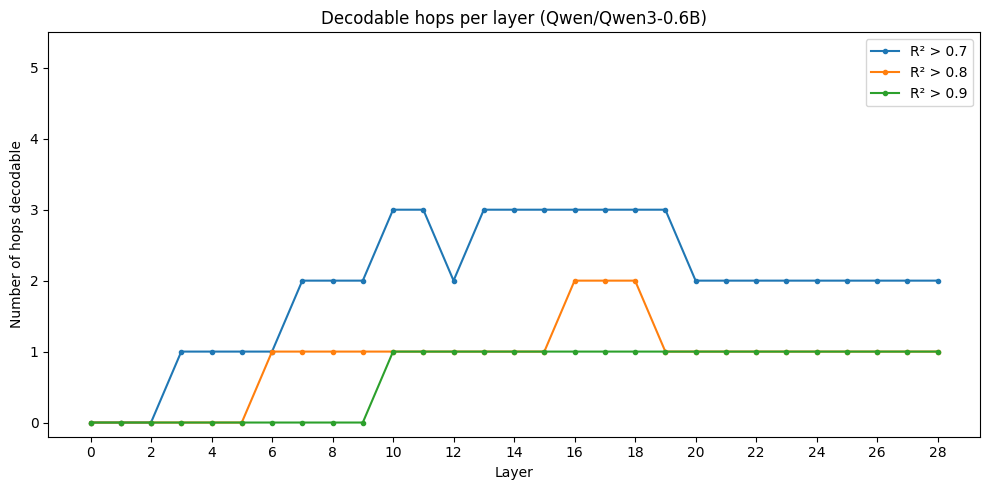

In [8]:
n_layers, max_hop = r2_matrix.shape
layers = np.arange(n_layers)

fig, ax = plt.subplots(figsize=(10, 5))
for thresh in [0.7, 0.8, 0.9]:
    counts = [np.sum(r2_matrix[l][~np.isnan(r2_matrix[l])] > thresh) for l in range(n_layers)]
    ax.plot(layers, counts, marker="o", markersize=3, label=f"R² > {thresh}")
ax.set_xlabel("Layer")
ax.set_ylabel("Number of hops decodable")
ax.set_title(f"Decodable hops per layer ({MODEL_NAME})")
ax.legend()
ax.set_ylim(-0.2, max_hop + 0.5)
ax.set_xticks(layers[::2])
fig.tight_layout()
fig.savefig("plot_decodable_hops.png", dpi=150)
plt.show()

### Plot 2: Per-hop R² across layers

One curve per hop level showing R² across layers, revealing the gradual emergence of each intermediate.

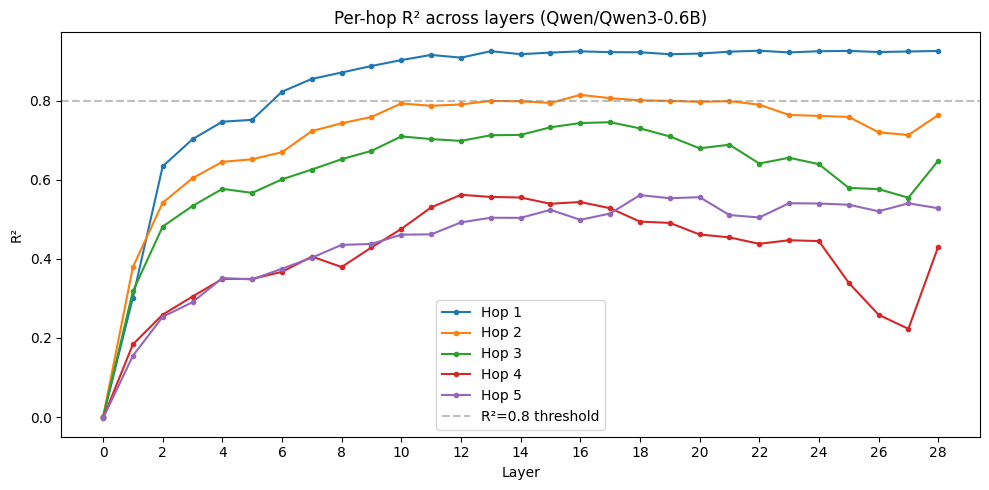

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
for hop in range(max_hop):
    vals = r2_matrix[:, hop]
    valid = ~np.isnan(vals)
    ax.plot(layers[valid], vals[valid], marker="o", markersize=3, label=f"Hop {hop+1}")
ax.axhline(0.8, color="gray", linestyle="--", alpha=0.5, label="R²=0.8 threshold")
ax.set_xlabel("Layer")
ax.set_ylabel("R²")
ax.set_title(f"Per-hop R² across layers ({MODEL_NAME})")
ax.legend()
ax.set_xticks(layers[::2])
fig.tight_layout()
fig.savefig("plot_per_hop_r2.png", dpi=150)
plt.show()